# 泰坦尼克号生还预测

## 一、引入工具包

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split

## 二、数据加载

In [2]:
data = pd.read_csv('../data/data.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 三、数据预处理

### 3.1 特征筛选

In [3]:
data.drop(["PassengerId","Name","Cabin","Ticket"],inplace = True,axis=1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


### 3.2 缺失值处理

In [5]:
missingDf = data.isnull().sum().sort_values(ascending=False).reset_index()
missingDf.columns = ['feature','missing_num']
missingDf['missingPercentage'] = missingDf['missing_num'] / data.shape[0]
missingDf.head()

,feature,missing_num,missingPercentage
0,Age,177,0.198653
1,Embarked,2,0.002245
2,Fare,0,0.000000
3,Parch,0,0.000000
4,SibSp,0,0.000000


In [6]:
# Age使用众数填充
data['Age'] = data['Age'].fillna(data['Age'].mode()[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [7]:
# Embarked缺失比例少，直接删除
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Sex         889 non-null object
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


### 3.2 特征转换

In [8]:
# 性别处理
data['Sex'] = (data["Sex"] == "male").astype("int")

In [9]:
# 登船港口处理
labels = data["Embarked"].unique().tolist()
labels

['S', 'C', 'Q']

In [10]:
data["Embarked"] = data["Embarked"].apply(lambda x:labels.index(x))
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,0
1,1,1,0,38.0,1,0,71.2833,1
2,1,3,0,26.0,0,0,7.9250,0
3,1,1,0,35.0,1,0,53.1000,0
4,0,3,1,35.0,0,0,8.0500,0


### 3.3 异常值处理

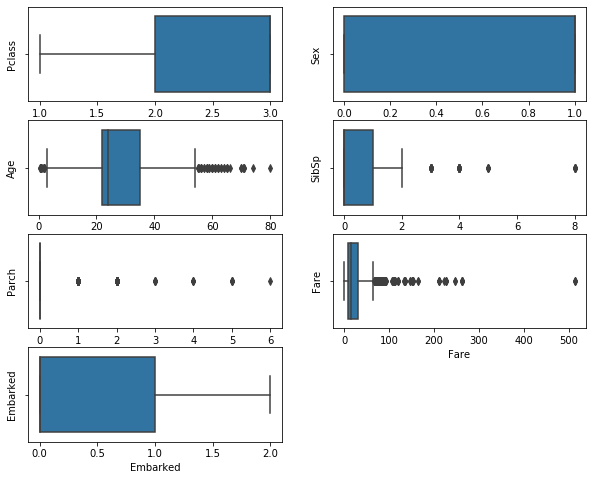

In [11]:
fig = plt.figure(figsize=(10,8))
for index,col in enumerate(data.iloc[:,1:].columns):
    fig.add_subplot(4,2,index+1)
    sns.boxplot(data[col])
    plt.ylabel(col)
plt.show()

## 四、模型训练

### 4.1 无参数模型构建

#### 区分特征和标签

In [12]:
# feature = data.iloc[:,1:]
# label = data.iloc[:,1]
feature = data.iloc[:,data.columns!="Survived"]
label = data.iloc[:,data.columns == "Survived"]

#### 切分训练集和测试集

In [13]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(feature,label,test_size = 0.3)
# Xtrain,Xtest,Ytrain,Ytest = train_test_split(x,y,test_size = 0.3)

#### 模型构建

In [14]:
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(Xtrain,Ytrain)
score = clf.score(Xtest,Ytest)
score

0.7865168539325843

#### 交叉验证

In [15]:
clf = DecisionTreeClassifier(random_state=30)
score = cross_val_score(clf,feature,label,cv=10).mean()
score

0.7829290091930541

### 4.2 超参数调优

In [16]:
clf = DecisionTreeClassifier(random_state=30,max_depth=5)
score = cross_val_score(clf,feature,label,cv=10).mean()
score

0.8020556690500511

#### 绘制max_depth超参数学习曲线

0.8189096016343207


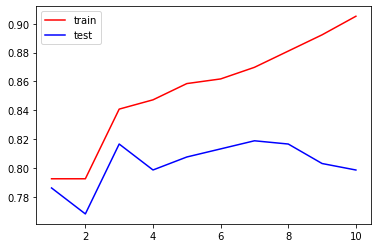

In [17]:
tr = []
te = []
for i in range(10):
    clf = DecisionTreeClassifier(random_state=25,max_depth=i+1,criterion="entropy")
    clf = clf.fit(Xtrain,Ytrain)
    score_tr = clf.score(Xtrain,Ytrain)
    score_te = cross_val_score(clf,feature,label,cv=10).mean()
    tr.append(score_tr)
    te.append(score_te)
    
print(max(te))
plt.plot(range(1,11),tr,color = "red",label="train")
plt.plot(range(1,11),te,color = "blue",label = "test")
plt.legend()
plt.show()

### 4.3 网格搜索

In [18]:
parameters = {
    "min_samples_leaf":[*range(1,50,5)],
    "min_impurity_decrease":[*np.linspace(0,0.5,50)]
}

clf = DecisionTreeClassifier(random_state=25,max_depth=3)
GS = GridSearchCV(clf,parameters,cv=10)
GS = GS.fit(Xtrain,Ytrain)

D:\Anaconda3\envs\Python3.6\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
GS.best_score_

0.8279742765273312

In [20]:
GS.best_params_

{'min_impurity_decrease': 0.0, 'min_samples_leaf': 1}

### 4.4 使用最优参数训练模型并绘制树形图

In [21]:
clf = DecisionTreeClassifier(random_state=25,max_depth=3,criterion="entropy",min_samples_leaf=16,min_impurity_decrease=0)
clf = clf.fit(Xtrain,Ytrain)
score = clf.score(Xtest,Ytest)
score

0.7865168539325843

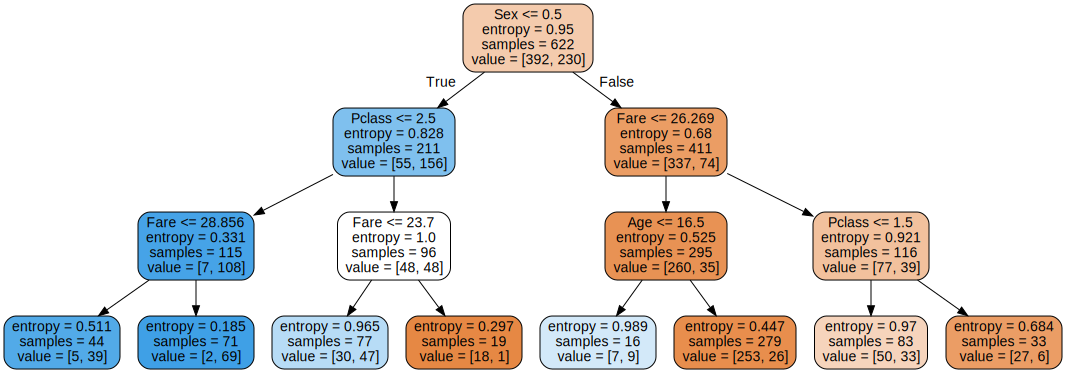

In [22]:
import graphviz
from sklearn import tree

feature_name = feature.columns.tolist()
dot_data = tree.export_graphviz(clf,out_file=None,feature_names=feature_name,filled=True,rounded=True)
graph = graphviz.Source(dot_data)
graph